# Trader Profiling & Personality Clustering
This notebook demonstrates an industry-inspired unsupervised learning approach to identify trader profiles using simulated trade logs and clustering.

## 📌 Objective
The goal is to understand trader behavior (aggressive, conservative, erratic) using trade logs. We generate data using real stock prices and simulate trades using realistic user behavior patterns. Unsupervised ML (KMeans) is used to profile these traders.

In [4]:
!pip install yfinance faker pandas scikit-learn matplotlib seaborn --quiet
import yfinance as yf
import pandas as pd
import random
from faker import Faker
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Step 1: Data Generation with yFinance + Faker

In [6]:
fake = Faker()
instruments = ['RELIANCE.BO', 'SBIN.BO', 'INFY.BO', 'TCS.BO', 'ITC.BO']
user_ids = [f"U{1000 + i}" for i in range(300)]
data = []



# STEP 1.1: Download once per symbol (no API spam)
price_dict = {}

for symbol in instruments:
    stock = yf.Ticker(symbol)
    time.sleep(2)
    hist = stock.history(period="30d")
    if hist.empty:
        price_dict[symbol] = []
    else:
        price_dict[symbol] = hist['Close'].dropna().tolist()


#  STEP 1.2: Simulate trades using downloaded data
for user in user_ids:
    for _ in range(random.randint(10, 20)):
        symbol = random.choice(instruments)
        prices = price_dict.get(symbol, [])
        if not prices:
            continue  # skip if no price history available
        price = round(random.choice(prices), 2)
        quantity = random.choice([10, 25, 50, 100])
        action = random.choice(['Buy', 'Sell'])
        timestamp = fake.date_time_between(start_date='-30d', end_date='now')
        pnl = round(random.uniform(-5000, 5000), 2)
        data.append([user, fake.uuid4()[:8], timestamp, symbol, action, quantity, price, pnl])

# STEP 1.3: Create dataframe and export
df = pd.DataFrame(data, columns=['user_id', 'trade_id', 'timestamp', 'instrument', 'action', 'quantity', 'price', 'pnl'])
df.to_csv('trader_logs_api_generated.csv', index=False)
df.head()

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

## Step 2: Feature Engineering


In [12]:
df=pd.read_csv('trader_logs_api_generated.csv')
df.head()


,user_id,trade_id,timestamp,instrument,action,quantity,price,pnl
0,U1000,b5d50b9b,2025-06-25 09:11:02,TCS.BO,Buy,100,3160.86,387.67
1,U1000,3e0223fc,2025-07-05 01:26:18,ITC.BO,Buy,10,447.19,456.35
2,U1000,47f03c14,2025-07-16 03:05:44,RELIANCE.BO,Buy,10,2407.52,4290.16
3,U1000,b8bf05de,2025-07-05 04:54:20,TCS.BO,Sell,25,3451.03,-2336.97
4,U1000,e6213b1c,2025-06-23 10:51:28,INFY.BO,Buy,50,1432.43,-1071.32


In [13]:

# Convert timestamp to datetime if needed
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Step 2.1: Aggregate to user-level features
features = df.groupby('user_id').agg({
    'quantity': 'mean',                          # Avg trade quantity
    'price': 'mean',                             # Avg trade price
    'pnl': ['mean', 'std'],                      # Mean and volatility of PnL
    'trade_id': 'count'                          # Total trades
}).reset_index()

# Flatten MultiIndex columns
features.columns = ['user_id', 'avg_quantity', 'avg_price', 'avg_pnl', 'pnl_volatility', 'num_trades']

# Step 2.2: Add Buy/Sell ratio and Win rate
buy_sell = df.pivot_table(index='user_id', columns='action', values='trade_id', aggfunc='count', fill_value=0)
buy_sell['buy_sell_ratio'] = buy_sell['Buy'] / (buy_sell['Sell'] + 1)
features = features.merge(buy_sell[['buy_sell_ratio']], on='user_id', how='left')

df['positive_trade'] = df['pnl'] > 0
win_rate = df.groupby('user_id')['positive_trade'].mean().reset_index().rename(columns={'positive_trade': 'win_rate'})
features = features.merge(win_rate, on='user_id', how='left')

features.fillna(0, inplace=True)  # Just in case
features.head()


,user_id,avg_quantity,avg_price,avg_pnl,pnl_volatility,num_trades,buy_sell_ratio,win_rate
0,U1000,53.684211,1919.494737,569.473684,2664.672232,19,1.222222,0.736842
1,U1001,43.214286,1827.525000,-260.365714,3322.894691,14,1.500000,0.500000
2,U1002,43.611111,1530.690556,680.999444,2867.973280,18,1.375000,0.611111
3,U1003,29.444444,2088.339444,517.411111,2520.266325,18,2.166667,0.555556
4,U1004,46.000000,1291.127333,509.571333,2930.120391,15,1.000000,0.533333


## Step 3: Clustering with KMeans + Evaluation

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

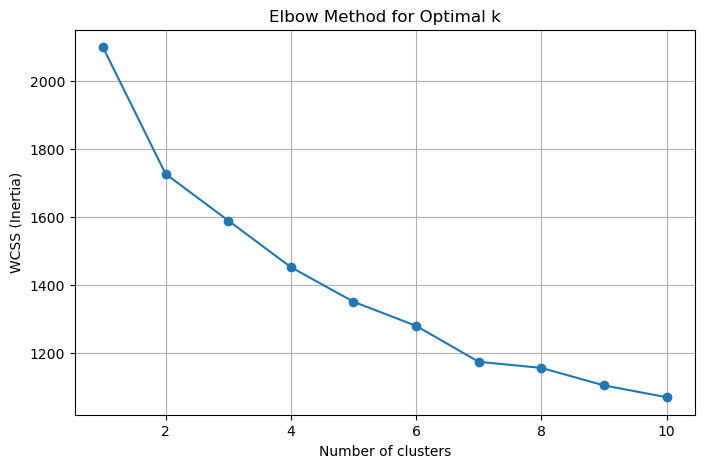

In [14]:

# Step 3.1: Prepare features for clustering
X = features.drop(['user_id'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3.2: Use Elbow Method to choose k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

In [15]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## Step 4.0: PCA Visualization of Clusters

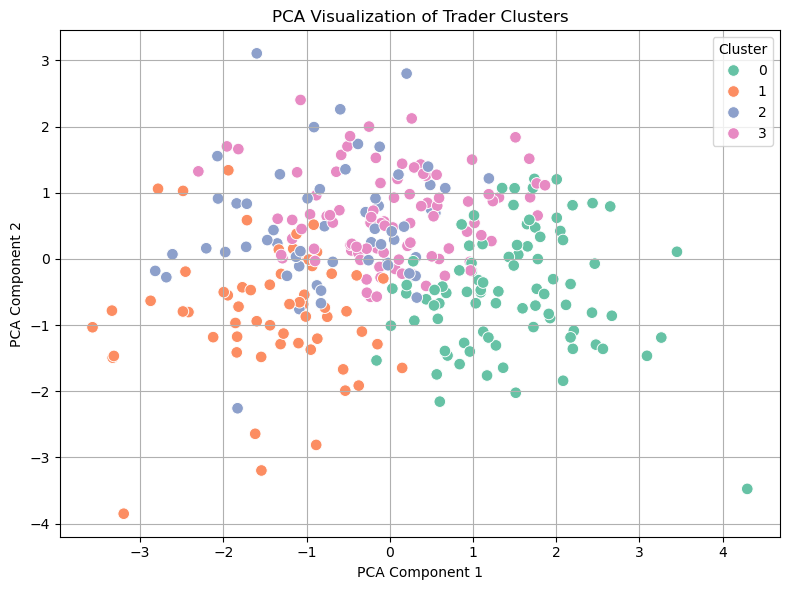

In [20]:
from sklearn.decomposition import PCA

# Step 4.0: PCA Visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Attach PCA results to the features DataFrame
features['pca1'] = components[:, 0]
features['pca2'] = components[:, 1]

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=features, x='pca1', y='pca2', hue='cluster', palette='Set2', s=70)
plt.title('PCA Visualization of Trader Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 4.1: Basic cluster summary
cluster_summary = features.groupby('cluster').mean(numeric_only=True)
print(cluster_summary)


         avg_quantity    avg_price     avg_pnl  pnl_volatility  num_trades  \
cluster                                                                      
0           46.051499  1558.940719  750.782647     2819.462859   13.034091   
1           42.782913  1594.083533 -722.504642     2573.893983   14.475410   
2           52.742557  1890.904532 -388.428400     3071.102818   13.543860   
3           44.416281  1660.637800   68.771207     2907.802278   18.297872   

         buy_sell_ratio  win_rate      pca1      pca2  
cluster                                                
0              1.027192  0.618282  1.446079 -0.479990  
1              0.865938  0.359798 -1.466733 -0.791561  
2              0.975276  0.437284 -0.710277  0.523762  
3              1.049329  0.515503  0.028741  0.645424  


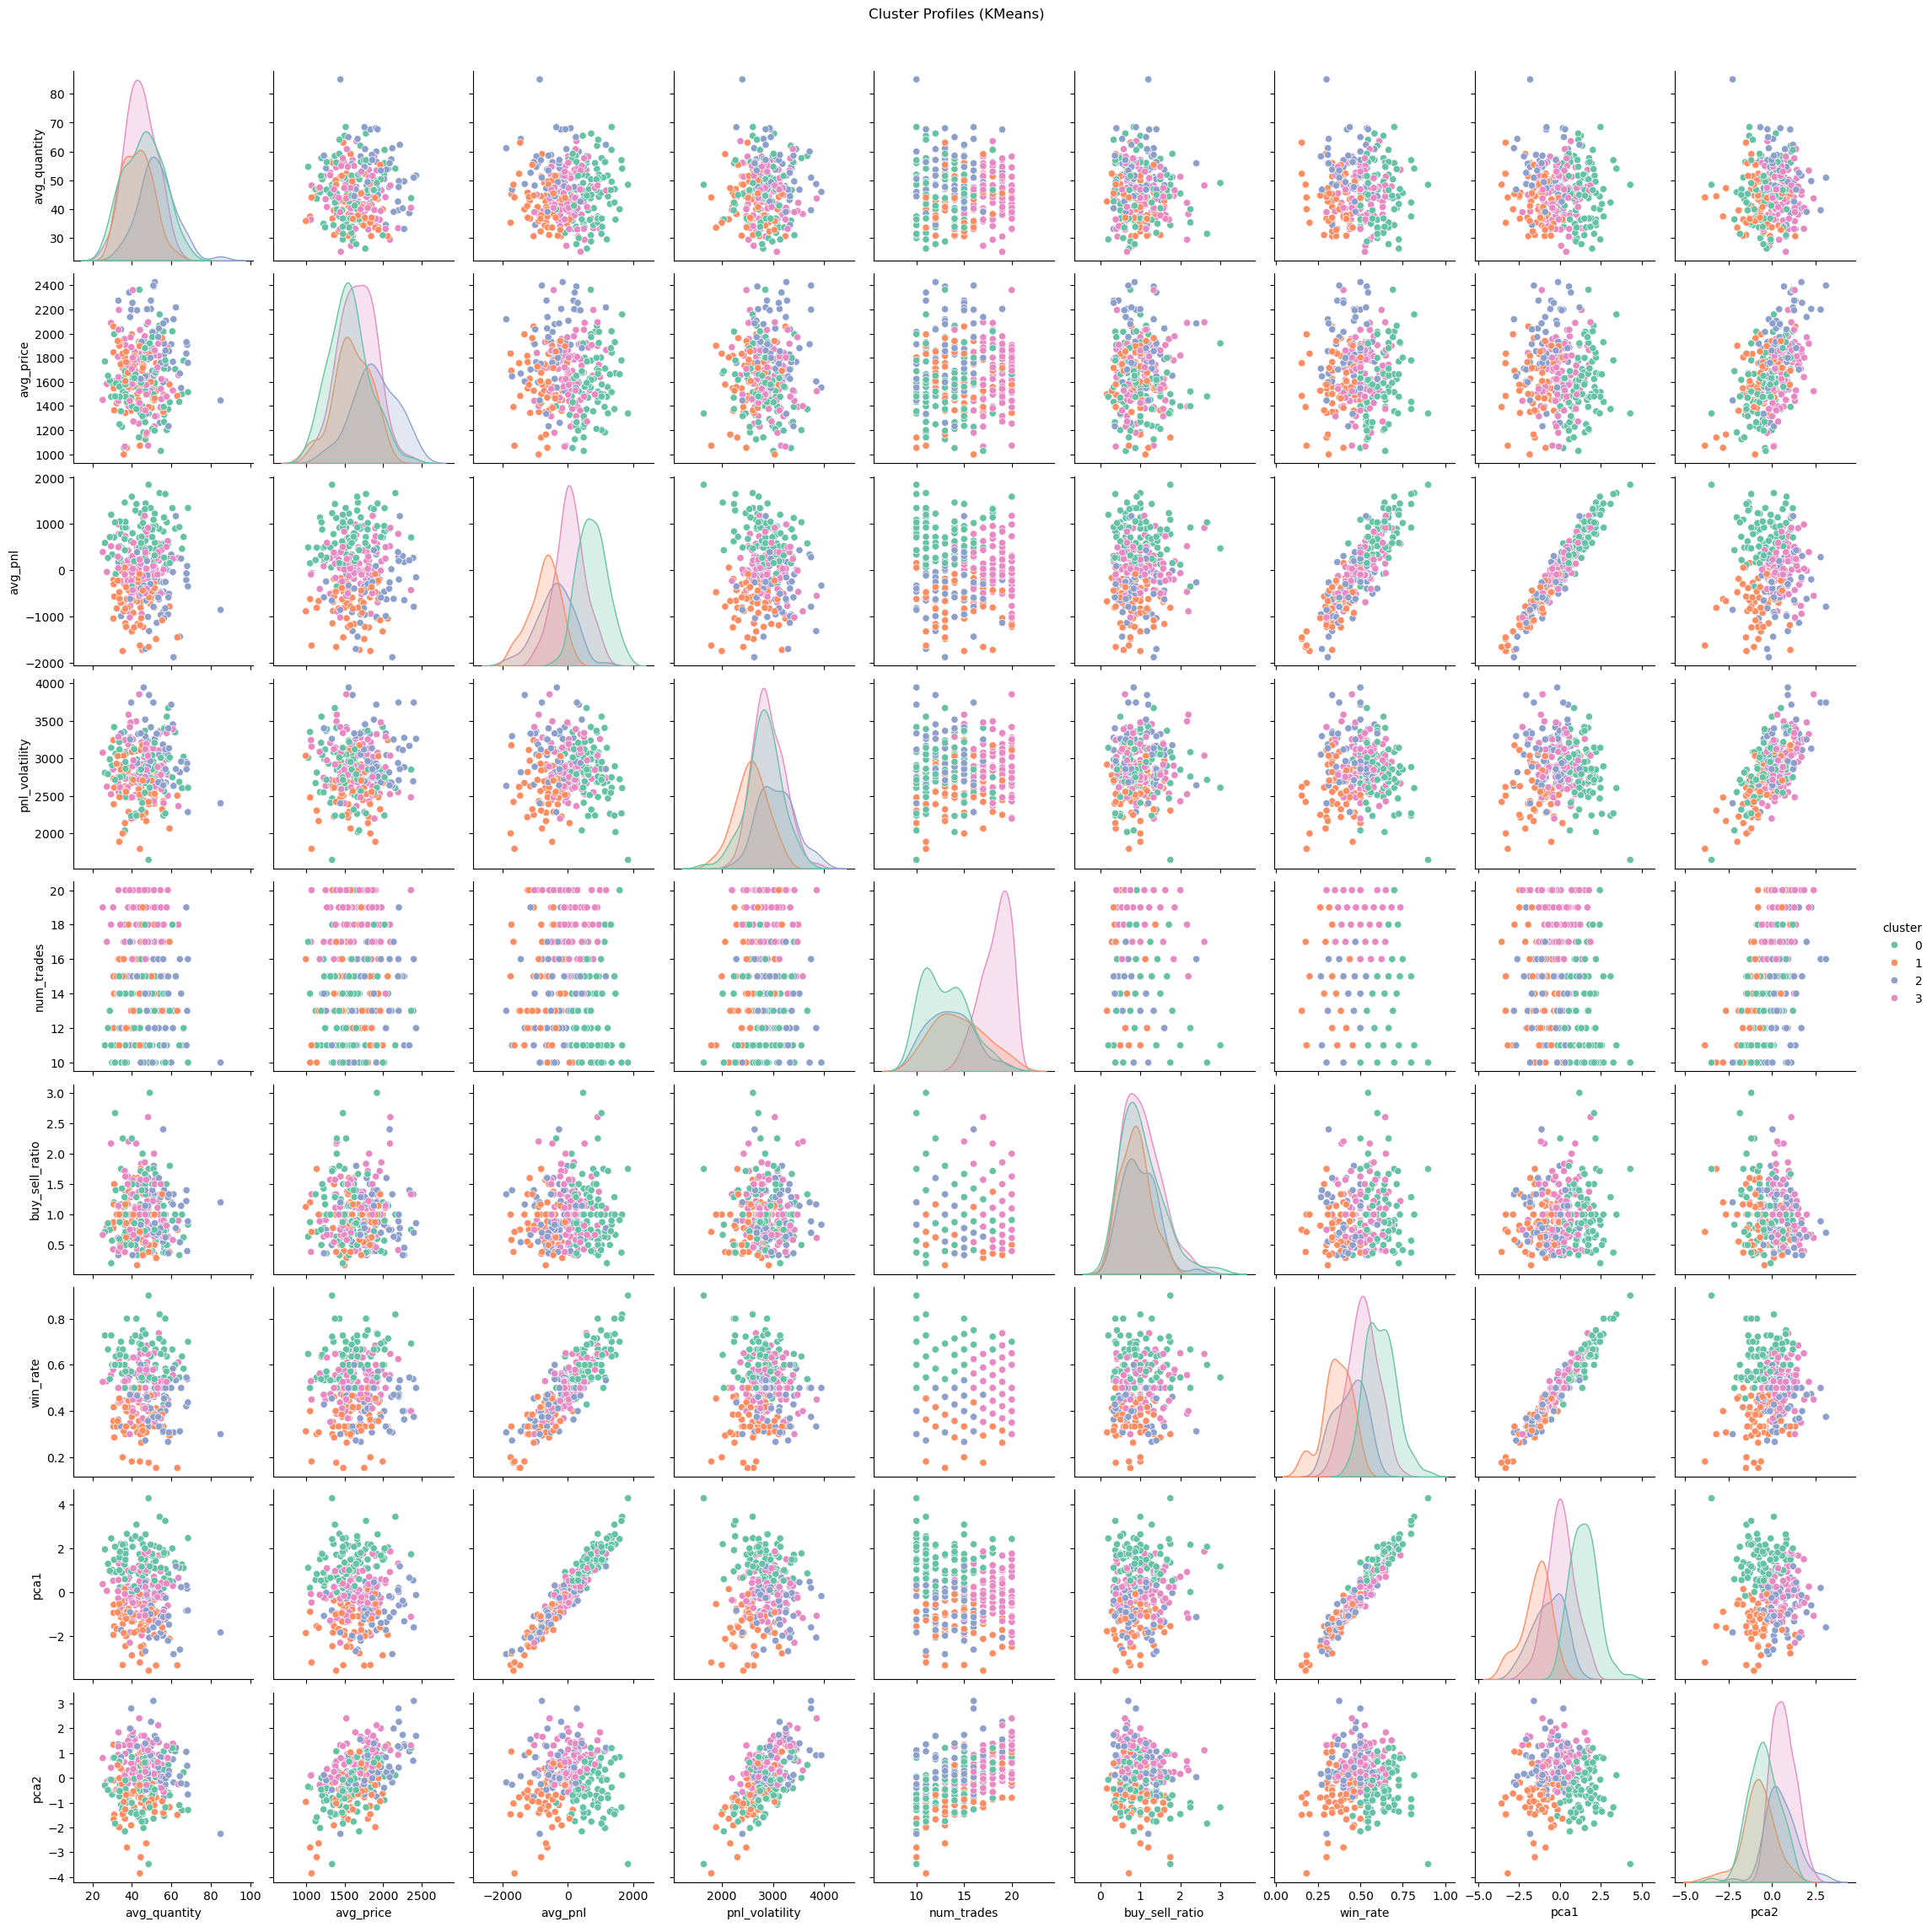

In [22]:

# Step 4.2: Visualize clusters using pairplot
sns.pairplot(features, hue='cluster', diag_kind='kde', palette='Set2')
plt.suptitle("Cluster Profiles (KMeans)", y=1.02)
plt.show()


In [24]:
# Step 4.3: Save the Final Output
features.to_csv("clustered_trader_profiles.csv", index=False)


## Step 5: Export Clustered Profiles

In [19]:
agg_df.to_csv('clustered_trader_profiles.csv')
print('Exported clustered_trader_profiles.csv')

NameError: name 'agg_df' is not defined